### Import Packages

In [114]:
import pandas as pd
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from collections import Counter
from numpy import array
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.model_selection import KFold

### Read Data

In [2]:
survey = pd.read_excel('DDS11_Data_Extract_with_labels.xlsx')

### Examine Data

In [3]:
survey.head()

,record - Record number,"Q1r1 - To begin, what is your age?",Q4 - What is your gender?,age - you are...,Q2 - In which state do you currently reside?,region - Region,QNEW3 - What is your employment status?,Q5 - Which category best describes your ethnicity?,QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?,QNEW2 - How old are the children in your home?-0-4 years,QNEW2 - How old are the children in your home?-5-9 years,QNEW2 - How old are the children in your home?-10-13 years,QNEW2 - How old are the children in your home?-14-18 years,QNEW2 - How old are the children in your home?-19-25 years,QNEW2 - How old are the children in your home?-26+ years,QNEW2 - How old are the children in your home?-Don't Know,"Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential.",Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television,Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR),Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob,Q8 - Which of the following media or home entertainment equipment does your household own?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription),Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player,Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player,Q8 - Which of the following media or home entertainment equipment does your household own?-Computer network/router in your home for wireless computer/laptop usage,Q8 - Which of the following media or home entertainment equipment does your household own?-Desktop computer,Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop computer,Q8 - Which of the following media or home entertainment equipment does your household own?-Tablet,Q8 - Which of the following media or home entertainment equipment does your household own?-Dedicated e-book reader,Q8 - Which of the following media or home entertainment equipment does your household own?-Smartphone,Q8 - Which of the following media or home entertainment equipment does your household own?-Basic mobile phone (not a smartphone),Q8 - Which of the following media or home entertainment equipment does your household own?-Smart watch,Q8 - Which of the following media or home entertainment equipment does your household own?-Fitness band,Q8 - Which of the following media or home entertainment equipment does your household own?-Virtual reality headset,Q8 - Which of the following media or home entertainment equipment does your household own?-Drone,Q8 - Which of the following media or home entertainment equipment does your household own?-None of the above,Q8 - Which of the following media or home entertainment equipment does your household own?-Don't Know,"Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Flat panel television","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Digital video recorder (DVR)","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Streaming media box or over-the-top box","Q10 - Of those products you indicated you do not currently own, which of the followin

In [4]:
survey.shape

(2131, 198)

### Rename/Shorten Columns IAW Survey Documentation

In [5]:
columns = [x.split(' ')[0] for x in survey.columns]
column_counter = Counter(columns)
#print(column_counter.most_common())
#print(columns)
new_columns = []
extension = 1
for i in range(len(columns)):
    col = columns[i]
    if column_counter[col] == 1:
        new_columns.append(col)
        extension = 1
    else:
        if (col != columns[i-1]):
            extension = 1
        new_columns.append(col+ "r" + str(extension))
        extension += 1
        #print(extension)
#print(new_columns)
survey.columns = new_columns

In [6]:
survey.head()

,record,Q1r1,Q4,age,Q2,region,QNEW3,Q5,QNEW1,QNEW2r1,QNEW2r2,QNEW2r3,QNEW2r4,QNEW2r5,QNEW2r6,QNEW2r7,Q6,Q8r1,Q8r2,Q8r3,Q8r4,Q8r5,Q8r6,Q8r7,Q8r8,Q8r9,Q8r10,Q8r11,Q8r12,Q8r13,Q8r14,Q8r15,Q8r16,Q8r17,Q8r18,Q8r19,Q8r20,Q8r21,Q10r1,Q10r2,Q10r3,Q10r4,Q10r5,Q10r6,Q10r7,Q10r8,Q10r9,Q10r10,Q10r11,Q10r12,Q10r13,Q10r14,Q10r15,Q10r16,Q10r17,Q10r18,Q10r19,Q10r20,Q10r21,Q11r1,Q11r2,Q11r3,Q11r4,Q11rNew1,Q11r5,Q11r6,Q11r7,Q11r8,Q11r9,Q11r10,Q11r12,Q11r14,Q11r15,Q11r17,Q11r18,Q11r19,Q11rNew2,Q11rNew3,Q11r22,Q15r1,Q15r2,Q15r3,Q15r4,Q16r1,Q16r2,Q16r3,Q16r4,Q17r1,Q17r2,Q17r3,Q17r4,Q22r1,Q22r2,Q22r3,Q22r4,Q22r5,Q22r6,Q22r7,Q22r8,Q22r9,Q22r10,Q22r11,Q22r12,Q22r13,Q22r14,Q22r15,Q22r16,Q22r17,Q22r18,Q22r19,Q22r20,Q22r21,Q22r22,Q22r23,Q22r24,Q22r25,Q22r26,Q22r27,Q22r28,Q22r29,Q22r30,Q22r31,Q22r32,Q22r33,Q22r34,Q22r35,Q22r36,Q22r37,Q26r1,Q26r2,Q26r3,Q26r4,Q26r5,Q26r6,Q26r7,Q26r8,Q26r9,Q26r10,Q26r11,Q26r12,Q36r1,Q36r2,Q36r3,Q36r4,Q36r5,Q36r6,Q36r7,Q36r8,Q36r9,Q36r10,Q29,Q37r1,Q37r2,Q37r3,Q37r4,Q37r5,Q37r6,Q37r7,Q37r8,Q37r9,Q37r10,QNEW19r1,QNEW19r2,QNEW19r3,QNEW19r4,QNEW19r5,QNEW19r6,QNEW20r1,QNEW20r2,QNEW20r3,QNEW20r4,QNEW20r5,QNEW24,QNEW28,QNEW29,Q73r2,Q73r3,Q73r4,Q73r5,Q73r6,Q73r7,Q73r8,Q73r9,Q73r10,Q73r11,Q73r12,Q73r13,Q39r1,Q39rNEW1,Q39rNEW2,Q39rNEW3,Q39rNEW4,Q39rNEW5,Q39r2,Q39r3,Q39r4,Q89,FINAL
0,4.0,36.0,Male,34-50,Georgia,South,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,No,No,Yes,Yes,No,No,No,"$50,000 to $99,999",No,No,No,No,No,No,Yes,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,No,No,No,No,No,No,Yes,Yes,No,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Yes,Frequently (every day/weekly),Television programming,Almost always (greater than 75% of the time),Always (close to 100% of the time),Always (close to 100% of the time),Almost always (greater than 75% of the time),Almost always (greater than 75% of the time),Almost always (greater than 75% of the time),Almost always (greater than 75% of the time),Always (close to 100% of the time),Almost always (greater than 75% of the time),Always (close to 100% of the time),Always (close to 100% of the time),Always (close to 100% of the time),Agree somewhat,Agree strongly,Agree somewhat,Agree somewhat,Agree strongly,Agree strongly,Agree strongly,Agree somewhat,Agree strongly,Magazine,0.083025
1,6.0,26.0,Female,20-26,New York,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,Yes,No,No,No,No,No,"$50,000 to $99,999",No,No,No,Yes,No,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,No,No,Yes,No,No,No,No,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,40.0,30.0,30.0,0.0,40.0,30.0,30.0,0.0,30.0,30.0,40.0,0.0,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,No,No,No,No,No,Yes,No,No,No,Yes,Yes,No,Yes,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,No,No,No,No,NaN,1.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,I am willing to pay $20 per month on top of wh...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,1.0,Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Frequently (every day/weekly),Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Frequently (every day/weekly),Occasionally (monthly),No,F

### Handle Null Values Appropriately

In [7]:
survey.isna().sum()

record         0
Q1r1           0
Q4             0
age            0
Q2             0
region         0
QNEW3          0
Q5             0
QNEW1          0
QNEW2r1     1270
QNEW2r2     1270
QNEW2r3     1270
QNEW2r4     1270
QNEW2r5     1270
QNEW2r6     1270
QNEW2r7     1270
Q6             0
Q8r1           0
Q8r2           0
Q8r3           0
Q8r4           0
Q8r5           0
Q8r6           0
Q8r7           0
Q8r8           0
Q8r9           0
Q8r10          0
Q8r11          0
Q8r12          0
Q8r13          0
Q8r14          0
Q8r15          0
Q8r16          0
Q8r17          0
Q8r18          0
Q8r19          0
Q8r20          0
Q8r21          0
Q10r1          0
Q10r2          0
Q10r3          0
Q10r4          0
Q10r5          0
Q10r6          0
Q10r7          0
Q10r8          0
Q10r9          0
Q10r10         0
Q10r11         0
Q10r12         0
Q10r13         0
Q10r14         0
Q10r15         0
Q10r16         0
Q10r17         0
Q10r18         0
Q10r19         0
Q10r20         0
Q10r21        

In [8]:
## Convert Q11 reponses to fall from 0-1, with 0 being 'na' and 1 being 'most important'
qnew2 = [x for x in survey.columns if 'QNEW2' in x]
#print("QNEW2\n", qnew2)

q11 = [x for x in survey.columns if 'Q11' in x]
#print("Q11\n", q11)

q22 = [x for x in survey.columns if 'Q22' in x]
#print("Q22\n", q22)

q36 = [x for x in survey.columns if 'Q36' in x]
#print("Q36\n", q36)

q37 = [x for x in survey.columns if 'Q37' in x]
#print("Q37\n", q37)

# Map to be applied to rank based columns
convert = {1.0 : 1.0, 2.0 : 0.67, 3.0 : 0.33, 0.0 : 0.0}


# Fill all qnew2 column NAs with "No"
survey[qnew2] = survey[qnew2].fillna("No")

# Fill all q11 column NAs with 0.0, then convert all values so that they fall from 0-1,
# with 1 being the 'most important', 0.67 being the second most, 0.33 third, and 0 no important
survey[q11] = survey[q11].fillna(0.0).applymap(convert.get)

# Fill all q22 column NAs with "No"
survey[q22] = survey[q22].fillna("No")

# Fill all q36 column NAs with 0.0, then convert all values so that they fall from 0-1,
# with 1 being the 'most important', 0.67 being the second most, 0.33 third, and 0 no important
survey[q36] = survey[q36].fillna(0.0).applymap(convert.get)

# Fill Q29 column NAs with a String NA, for OHE later
survey['Q29'].fillna("NA", inplace = True)

# Fill all q37 column NAs with 0.0, then convert all values so that they fall from 0-1,
# with 1 being the 'most important', 0.67 being the second most, 0.33 third, and 0 no important
survey[q37] = survey[q37].fillna(0.0).applymap(convert.get)

# Fill qnew29 column NAs with "None"
survey['QNEW29'].fillna("None", inplace = True)


display(survey.head())


,record,Q1r1,Q4,age,Q2,region,QNEW3,Q5,QNEW1,QNEW2r1,QNEW2r2,QNEW2r3,QNEW2r4,QNEW2r5,QNEW2r6,QNEW2r7,Q6,Q8r1,Q8r2,Q8r3,Q8r4,Q8r5,Q8r6,Q8r7,Q8r8,Q8r9,Q8r10,Q8r11,Q8r12,Q8r13,Q8r14,Q8r15,Q8r16,Q8r17,Q8r18,Q8r19,Q8r20,Q8r21,Q10r1,Q10r2,Q10r3,Q10r4,Q10r5,Q10r6,Q10r7,Q10r8,Q10r9,Q10r10,Q10r11,Q10r12,Q10r13,Q10r14,Q10r15,Q10r16,Q10r17,Q10r18,Q10r19,Q10r20,Q10r21,Q11r1,Q11r2,Q11r3,Q11r4,Q11rNew1,Q11r5,Q11r6,Q11r7,Q11r8,Q11r9,Q11r10,Q11r12,Q11r14,Q11r15,Q11r17,Q11r18,Q11r19,Q11rNew2,Q11rNew3,Q11r22,Q15r1,Q15r2,Q15r3,Q15r4,Q16r1,Q16r2,Q16r3,Q16r4,Q17r1,Q17r2,Q17r3,Q17r4,Q22r1,Q22r2,Q22r3,Q22r4,Q22r5,Q22r6,Q22r7,Q22r8,Q22r9,Q22r10,Q22r11,Q22r12,Q22r13,Q22r14,Q22r15,Q22r16,Q22r17,Q22r18,Q22r19,Q22r20,Q22r21,Q22r22,Q22r23,Q22r24,Q22r25,Q22r26,Q22r27,Q22r28,Q22r29,Q22r30,Q22r31,Q22r32,Q22r33,Q22r34,Q22r35,Q22r36,Q22r37,Q26r1,Q26r2,Q26r3,Q26r4,Q26r5,Q26r6,Q26r7,Q26r8,Q26r9,Q26r10,Q26r11,Q26r12,Q36r1,Q36r2,Q36r3,Q36r4,Q36r5,Q36r6,Q36r7,Q36r8,Q36r9,Q36r10,Q29,Q37r1,Q37r2,Q37r3,Q37r4,Q37r5,Q37r6,Q37r7,Q37r8,Q37r9,Q37r10,QNEW19r1,QNEW19r2,QNEW19r3,QNEW19r4,QNEW19r5,QNEW19r6,QNEW20r1,QNEW20r2,QNEW20r3,QNEW20r4,QNEW20r5,QNEW24,QNEW28,QNEW29,Q73r2,Q73r3,Q73r4,Q73r5,Q73r6,Q73r7,Q73r8,Q73r9,Q73r10,Q73r11,Q73r12,Q73r13,Q39r1,Q39rNEW1,Q39rNEW2,Q39rNEW3,Q39rNEW4,Q39rNEW5,Q39r2,Q39r3,Q39r4,Q89,FINAL
0,4.0,36.0,Male,34-50,Georgia,South,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,No,No,Yes,Yes,No,No,No,"$50,000 to $99,999",No,No,No,No,No,No,Yes,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,Yes,No,No,0.0,0.0,0.00,0.00,0.0,0.0,0.33,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,0.67,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Yes,Yes,No,No,1.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.33,0.67,NA,1.00,0.0,0.00,0.00,0.00,0.0,0.67,0.33,0.00,0.00,Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Frequently (every day/weekly),Yes,Frequently (every day/weekly),Television programming,Almost always (greater than 75% of the time),Always (close to 100% of the time),Always (close to 100% of the time),Almost always (greater than 75% of the time),Almost always (greater than 75% of the time),Almost always (greater than 75% of the time),Almost always (greater than 75% of the time),Always (close to 100% of the time),Almost always (greater than 75% of the time),Always (close to 100% of the time),Always (close to 100% of the time),Always (close to 100% of the time),Agree somewhat,Agree strongly,Agree somewhat,Agree somewhat,Agree strongly,Agree strongly,Agree strongly,Agree somewhat,Agree strongly,Magazine,0.083025
1,6.0,26.0,Female,20-26,New York,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,Yes,No,No,No,No,No,"$50,000 to $99,999",No,No,No,Yes,No,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,No,No,Yes,No,No,No,No,0.0,0.0,0.00,0.67,0.0,0.0,0.00,0.0,0.0,0.0,0.33,0.0,0.0,1.00,0.0,0.00,0.0,0.0,0.0,0.0,40.0,30.0,30.0,0.0,40.0,30.0,30.0,0.0,30.0,30.0,40.0,0.0,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,No,No,No,No,No,Yes,No,No,No,Yes,Yes,No,Yes,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,No,No,No,No,0.00,1.0,0.67,0.0,0.00,0.33,0.0,0.0,0.00,0.00,I am willing to pay $20 per month on top of wh...,0.00,0.0,0.00,0.00,0.33,0.0,0.00,0.67,0.00,1.00,Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Frequently (every day/weekly),Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Occasionally (monthly),Frequently (every day/weekly),Occasionally (monthly),No

### Feature Encoding

In [9]:
# Get dummies for OHE
survey2 = pd.get_dummies(survey)
for column in survey2.columns:
    print(column)

record
Q1r1
Q11r1
Q11r2
Q11r3
Q11r4
Q11rNew1
Q11r5
Q11r6
Q11r7
Q11r8
Q11r9
Q11r10
Q11r12
Q11r14
Q11r15
Q11r17
Q11r18
Q11r19
Q11rNew2
Q11rNew3
Q11r22
Q15r1
Q15r2
Q15r3
Q15r4
Q16r1
Q16r2
Q16r3
Q16r4
Q17r1
Q17r2
Q17r3
Q17r4
Q36r1
Q36r2
Q36r3
Q36r4
Q36r5
Q36r6
Q36r7
Q36r8
Q36r9
Q36r10
Q37r1
Q37r2
Q37r3
Q37r4
Q37r5
Q37r6
Q37r7
Q37r8
Q37r9
Q37r10
FINAL
Q4_Female
Q4_Male
age_14-19
age_20-26
age_27-33
age_34-50
age_51-69
age_70 or older
Q2_Alabama
Q2_Alaska
Q2_Arizona
Q2_Arkansas
Q2_California
Q2_Colorado
Q2_Connecticut
Q2_Delaware
Q2_District of Columbia
Q2_Florida
Q2_Georgia
Q2_Hawaii
Q2_Idaho
Q2_Illinois
Q2_Indiana
Q2_Iowa
Q2_Kansas
Q2_Kentucky
Q2_Louisiana
Q2_Maine
Q2_Maryland
Q2_Massachusetts
Q2_Michigan
Q2_Minnesota
Q2_Mississippi
Q2_Missouri
Q2_Montana
Q2_Nebraska
Q2_Nevada
Q2_New Hampshire
Q2_New Jersey
Q2_New Mexico
Q2_New York
Q2_North Carolina
Q2_North Dakota
Q2_Ohio
Q2_Oklahoma
Q2_Oregon
Q2_Pennsylvania
Q2_Rhode Island
Q2_South Carolina
Q2_South Dakota
Q2_Tennessee
Q2_Texas
Q2_Utah

### Normalize Data

In [10]:
# Normalize
#select_dtypes(include=np.number)
survey_norm = (survey2 - survey2.min())/(survey2.max() - survey2.min())
# Drop columns that have NAs after normalization- these were constant columns and provide no information
survey_norm = survey_norm.dropna(axis=1, how='all')
# Drop 'Record' and 'FINAL' columns
survey_norm.drop(columns = ['record', 'FINAL'], inplace = True)
display(survey_norm.head())

,Q1r1,Q11r1,Q11r2,Q11r3,Q11r4,Q11rNew1,Q11r5,Q11r6,Q11r7,Q11r8,Q11r9,Q11r10,Q11r12,Q11r14,Q11r15,Q11r17,Q11r18,Q11r19,Q11rNew2,Q11rNew3,Q15r1,Q15r2,Q15r3,Q15r4,Q16r1,Q16r2,Q16r3,Q16r4,Q17r1,Q17r2,Q17r3,Q17r4,Q36r1,Q36r2,Q36r3,Q36r4,Q36r5,Q36r6,Q36r7,Q36r8,Q36r9,Q36r10,Q37r1,Q37r2,Q37r3,Q37r4,Q37r5,Q37r6,Q37r7,Q37r8,Q37r9,Q37r10,Q4_Female,Q4_Male,age_14-19,age_20-26,age_27-33,age_34-50,age_51-69,age_70 or older,Q2_Alabama,Q2_Alaska,Q2_Arizona,Q2_Arkansas,Q2_California,Q2_Colorado,Q2_Connecticut,Q2_Delaware,Q2_District of Columbia,Q2_Florida,Q2_Georgia,Q2_Hawaii,Q2_Idaho,Q2_Illinois,Q2_Indiana,Q2_Iowa,Q2_Kansas,Q2_Kentucky,Q2_Louisiana,Q2_Maine,Q2_Maryland,Q2_Massachusetts,Q2_Michigan,Q2_Minnesota,Q2_Mississippi,Q2_Missouri,Q2_Montana,Q2_Nebraska,Q2_Nevada,Q2_New Hampshire,Q2_New Jersey,Q2_New Mexico,Q2_New York,Q2_North Carolina,Q2_North Dakota,Q2_Ohio,Q2_Oklahoma,Q2_Oregon,Q2_Pennsylvania,Q2_Rhode Island,Q2_South Carolina,Q2_South Dakota,Q2_Tennessee,Q2_Texas,Q2_Utah,Q2_Vermont,Q2_Virginia,Q2_Washington,Q2_West Virginia,Q2_Wisconsin,Q2_Wyoming,region_Midwest,region_Northeast,region_South,region_West,QNEW3_Employed full-time or part-time,QNEW3_Retired,QNEW3_Self-employed,QNEW3_Student,QNEW3_Unemployed,Q5_African American,Q5_Caribbean,Q5_East Asian or Southeast Asian,Q5_Hispanic,Q5_Middle Eastern,Q5_Multiracial,"Q5_Pacific Islander (including Native Hawaiian, Native American, or Native Alaskan)",Q5_Something else not listed here,"Q5_South Asian (India, Pakistan, Sri Lanka)",Q5_White or Caucasian (Non-Hispanic),QNEW1_No,QNEW1_Yes,QNEW2r1_No,QNEW2r1_Yes,QNEW2r2_No,QNEW2r2_Yes,QNEW2r3_No,QNEW2r3_Yes,QNEW2r4_No,QNEW2r4_Yes,QNEW2r5_No,QNEW2r5_Yes,QNEW2r6_No,QNEW2r6_Yes,"Q6_$100,000 to $299,999","Q6_$30,000 to $49,999","Q6_$50,000 to $99,999",Q6_Do not know,"Q6_Less than $29,999","Q6_More than $300,000",Q8r1_No,Q8r1_Yes,Q8r2_No,Q8r2_Yes,Q8r3_No,Q8r3_Yes,Q8r4_No,Q8r4_Yes,Q8r5_No,Q8r5_Yes,Q8r6_No,Q8r6_Yes,Q8r7_No,Q8r7_Yes,Q8r8_No,Q8r8_Yes,Q8r9_No,Q8r9_Yes,Q8r10_No,Q8r10_Yes,Q8r11_No,Q8r11_Yes,Q8r12_No,Q8r12_Yes,Q8r13_No,Q8r13_Yes,Q8r14_No,Q8r14_Yes,Q8r15_No,Q8r15_Yes,Q8r16_No,Q8r16_Yes,Q8r17_No,Q8r17_Yes,Q8r18_No,Q8r18_Yes,Q8r19_No,Q8r19_Yes,Q8r20_No,Q8r20_Yes,Q10r1_No,Q10r1_Yes,Q10r2_No,Q10r2_Yes,Q10r3_No,Q10r3_Yes,Q10r4_No,Q10r4_Yes,Q10r5_No,Q10r5_Yes,Q10r6_No,Q10r6_Yes,Q10r7_No,Q10r7_Yes,Q10r8_No,Q10r8_Yes,Q10r9_No,Q10r9_Yes,Q10r10_No,Q10r10_Yes,Q10r11_No,Q10r11_Yes,Q10r12_No,Q10r12_Yes,Q10r13_No,Q10r13_Yes,Q10r14_No,Q10r14_Yes,Q10r15_No,Q10r15_Yes,Q10r16_No,Q10r16_Yes,Q10r17_No,Q10r17_Yes,Q10r18_No,Q10r18_Yes,Q10r19_No,Q10r19_Yes,Q10r20_No,Q10r20_Yes,Q22r1_No,Q22r1_Yes,Q22r2_No,Q22r2_Yes,Q22r3_No,Q22r3_Yes,Q22r4_No,Q22r4_Yes,Q22r5_No,Q22r5_Yes,Q22r6_No,Q22r6_Yes,Q22r7_No,Q22r7_Yes,Q22r8_No,Q22r8_Yes,Q22r9_No,Q22r9_Yes,Q22r10_No,Q22r10_Yes,Q22r11_No,Q22r11_Yes,Q22r12_No,Q22r12_Yes,Q22r13_No,Q22r13_Yes,Q22r14_No,Q22r14_Yes,Q22r15_No,Q22r15_Yes,Q22r16_No,Q22r16_Yes,Q22r17_No,Q22r17_Yes,Q22r18_No,Q22r18_Yes,Q22r19_No,Q22r19_Yes,Q22r20_No,Q22r20_Yes,Q22r21_No,Q22r21_Yes,Q22r22_No,Q22r22_Yes,Q22r23_No,Q22r23_Yes,Q22r24_No,Q22r24_Yes,Q22r25_No,Q22r25_Yes,Q22r26_No,Q22r26_Yes,Q22r27_No,Q22r27_Yes,Q22r28_No,Q22r28_Yes,Q22r29_No,Q22r29_Yes,Q22r30_No,Q22r30_Yes,Q22r31_No,Q22r31_Yes,Q22r32_No,Q22r32_Yes,Q22r33_No,Q22r33_Yes,Q22r34_No,Q22r34_Yes,Q22r35_No,Q22r35_Yes,Q22r36_No,Q22r36_Yes,Q26r1_No,Q26r1_Yes,Q26r2_No,Q26r2_Yes,Q26r3_No,Q26r3_Yes,Q26r4_No,Q26r4_Yes,Q26r5_No,Q26r5_Yes,Q26r6_No,Q26r6_Yes,Q26r7_No,Q26r7_Yes,Q26r8_No,Q26r8_Yes,Q26r9_No,Q26r9_Yes,Q26r10_No,Q26r10_Yes,Q26r11_No,Q26r11_Yes,Q29_I am not willing to pay more for faster download speeds as my current speed is sufficient for my needs,Q29_I am willing to pay $10 per month on top of what I already pay,Q29_I am willing to pay $20 per month on top of what I already pay,Q29_I am willing to pay $30 or more per month on top of what I already pay,Q29_I am willing to pay $5 per month on top of what I already pay,Q29_I prefer faster speed but I am unwilling to pay more than I already do,Q

In [41]:
gender_age_location_employment = survey_norm.iloc[:,52:130].head(5)

In [11]:
survey.shape

(2131, 198)

In [12]:
survey_norm.shape

(2131, 500)

In [13]:
frames = [survey,survey_norm]
df = pd.concat(frames, axis = 1)


### PCA Dimensionality Reduction

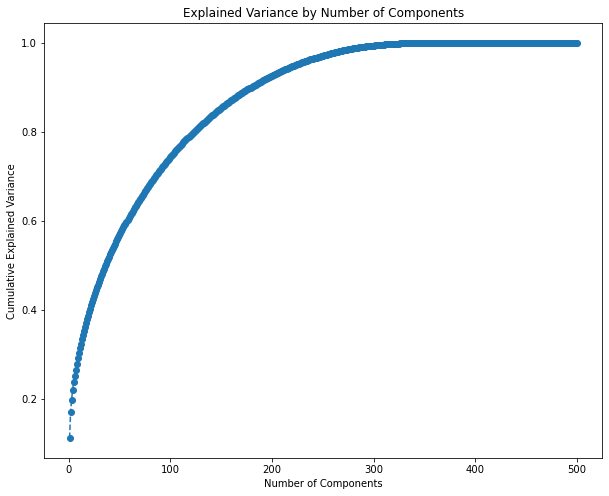

In [14]:
pca = PCA()
pca.fit(survey_norm)
pca_data = pca.fit_transform(survey_norm)
plt.figure(figsize = (10, 8))
plt.plot(range(1,501), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [15]:
# Keep the number of components that explain ~80% of the data
pca = PCA(n_components = 100)
pca.fit(survey_norm)
scores_pca = pca.transform(survey_norm)

### Perform K means Clustering

Text(0, 0.5, 'Inertia')

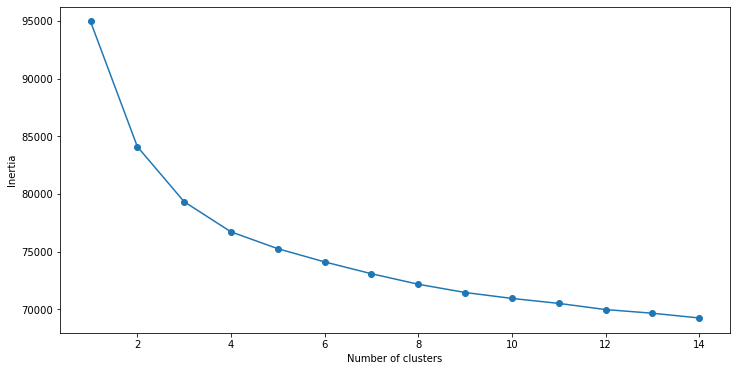

In [16]:
# https://365datascience.com/tutorials/python-tutorials/pca-k-means/
# Also referenced 'Online retailing' Jupyter notebook for how to plot k means clustering plot at 
# different levels of k
SSE = []
for cluster in range(1,15):
    kmeans_pca = KMeans(n_clusters = cluster, init='k-means++')
    kmeans_pca.fit(scores_pca)
    SSE.append(kmeans_pca.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,15), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### Determine Clusters by Silhouette Score

In [17]:
for k in range(2,5):
    kmeans = KMeans(n_clusters = k, init='k-means++',n_init=200,algorithm='elkan')
    kmeans.fit(survey_norm)
    print(silhouette_score(scores_pca, kmeans.labels_, metric='euclidean'))

0.10253339784843347
0.1051843253165762
0.0990412618715619


### Export Pickle of Cleaned, Encoded, Normalized Data

In [18]:
survey_norm.to_pickle("survey_clean.p")

# Visualizing our clusters

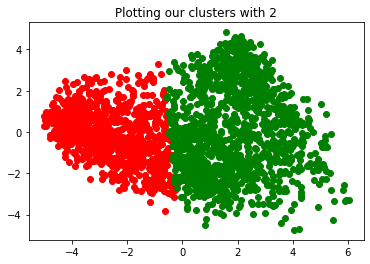

In [19]:
#https://www.askpython.com/python/examples/plot-k-means-clusters-python
kmeans = KMeans(n_clusters=2, init='k-means++',n_init=200,algorithm='elkan')
preds = kmeans.fit_predict(pca_data)
#print(preds,preds.shape)
reds = pca_data[preds==0]
greens = pca_data[preds==1]
plt.scatter(reds[:,0] , reds[:,1], color = 'red')
plt.scatter(greens[:,0] , greens[:,1],color = 'green')
plt.title("Plotting our clusters with 2")
plt.show()
# Of note here there are alot of point that are very close to eachother, meaning that there are alot of similar points in
# the middle - if we are using a binary, or even multiclass classification, a SVM may be a good choice
#

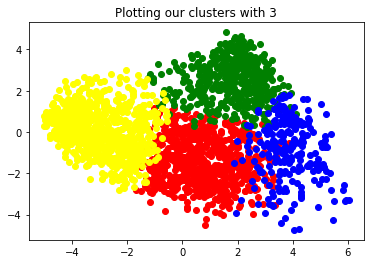

In [144]:
#https://www.askpython.com/python/examples/plot-k-means-clusters-python
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=200,algorithm='elkan')
preds = kmeans.fit_predict(pca_data)
#print(preds,preds.shape)
reds = pca_data[preds==0]
greens = pca_data[preds==1]
blues = pca_data[preds==2]
yellows = pca_data[preds==3]
plt.scatter(reds[:,0] , reds[:,1], color = 'red')
plt.scatter(greens[:,0] , greens[:,1],color = 'green')
plt.scatter(blues[:,0] , blues[:,1],color = 'blue')
plt.scatter(yellows[:,0],yellows[:,1], color='yellow')
plt.title("Plotting our clusters with 3")
plt.show()

In [21]:
## WE DEFINITELY NEED MORE ON UNSUPERVISED LEARNING STUFF - BUT GOING TO MOVE ON TO SUPERVISED

In [22]:
#y_cols = survey_norm.iloc[:,490:]
#column_for_y =[]
#for i in range (y_cols.shape[0]):
    #row = list(y_cols.loc[i])
    #ohe_str =[str(int(x)) for x in row ]
    #OHE = str("".join(ohe_str))
    #column_for_y.append(OHE)
#survey_norm["OHE_NEWS_OUTLET"] = column_for_y
#y = survey_norm["OHE_NEWS_OUTLET"]

# Supervised Learning


In [56]:
gender_age_location_employment = survey_norm.iloc[:,52:130]
#490

#Q89 is news source


In [115]:
X = survey_norm.iloc[:,:490]
kb = SelectKBest(k=5)
pred = kb.fit_transform(X,y)
preds = kb.get_support()
top_five_index = [x for x, i in enumerate(preds) if i ==True ]
cols = list(X.columns)
top_cols = [cols[x] for x in top_five_index]
X = X[top_cols]
y = survey['Q89']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']} 
  
grid = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.434 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.434 total time=   0.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.440 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.434 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.424 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.437 total time=   0.2s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.452 total time=   0.2s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.457 total time=   0.2s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.449 total time=   0.2s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.435 total time=   0.2s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.443 total time=   0.3s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

[CV 2/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.393 total time=   0.2s
[CV 3/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.393 total time=   0.2s
[CV 4/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.393 total time=   0.2s
[CV 5/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.394 total time=   0.2s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.428 total time=   0.4s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.443 total time=   0.4s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.431 total time=   0.4s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.431 total time=   0.4s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.418 total time=   0.4s
[CV 1/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.452 total time=   0.2s
[CV 2/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.469 total time=   0.2s
[CV 3/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.463 total time=   0.2s
[CV 4/5] END ....C=1, gamma=

[CV 4/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.463 total time=   0.2s
[CV 5/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.459 total time=   0.2s
[CV 1/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.393 total time=   0.2s
[CV 2/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.393 total time=   0.2s
[CV 3/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.393 total time=   0.2s
[CV 4/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.393 total time=   0.2s
[CV 5/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.394 total time=   0.2s
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.393 total time=   0.4s
[CV 2/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.393 total time=   0.4s
[CV 3/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.393 total time=   0.4s
[CV 4/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.393 total time=   0.4s
[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.394 total time=   0.4s
[CV 1/5] END .C=10, gamma=0.

[CV 1/5] END ....C=1000, gamma=1, kernel=linear;, score=0.443 total time= 1.6min
[CV 2/5] END ....C=1000, gamma=1, kernel=linear;, score=0.475 total time= 2.2min
[CV 3/5] END ....C=1000, gamma=1, kernel=linear;, score=0.466 total time= 7.2min
[CV 4/5] END ....C=1000, gamma=1, kernel=linear;, score=0.466 total time= 9.9min
[CV 5/5] END ....C=1000, gamma=1, kernel=linear;, score=0.456 total time=17.2min
[CV 1/5] END ......C=1000, gamma=1, kernel=poly;, score=0.460 total time=  48.8s
[CV 2/5] END ......C=1000, gamma=1, kernel=poly;, score=0.475 total time= 1.0min
[CV 3/5] END ......C=1000, gamma=1, kernel=poly;, score=0.472 total time=  50.8s
[CV 4/5] END ......C=1000, gamma=1, kernel=poly;, score=0.452 total time=  55.2s
[CV 5/5] END ......C=1000, gamma=1, kernel=poly;, score=0.444 total time=  58.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.449 total time=   3.5s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.475 total time=   3.4s
[CV 3/5] END .....C=1000, ga

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [137]:
grid.best_params_

{'C': 1000, 'gamma': 1, 'kernel': 'linear'}

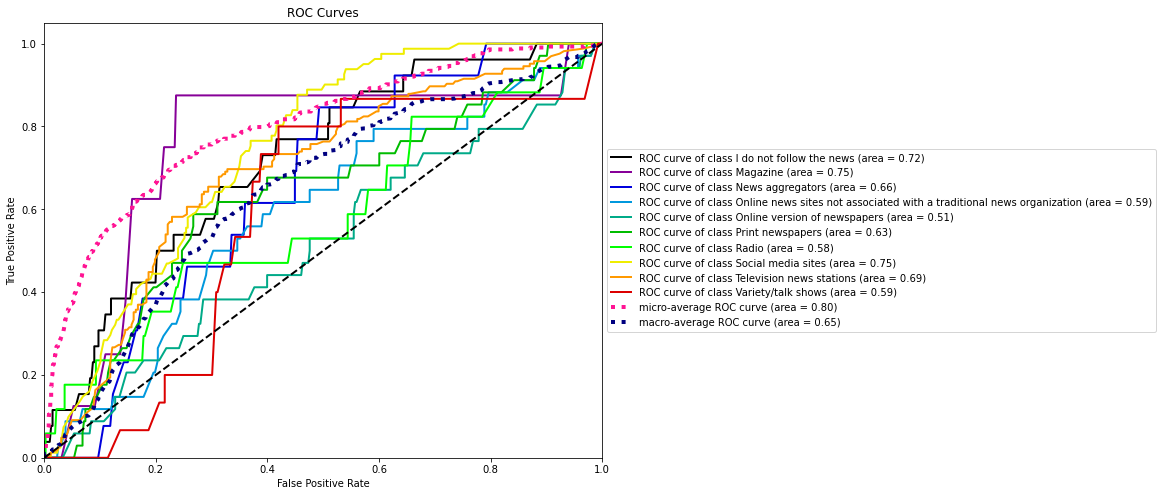

In [123]:
y_score = grid.predict_proba(X_test)
# https://towardsdatascience.com/how-to-deal-with-imbalanced-multiclass-datasets-in-python-fe0bb3f2b669
# Plot metrics 
ax = plot_roc(y_test, y_score)
ax.figure.set_size_inches(10,8)
plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [138]:
balance = [{1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1}, {1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},
          {1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},{1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},
          {1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},{1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},
          {1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},{1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},
          {1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1},{1:1 , 2:1, 3:1, 4:1,5:1,6:1,7:1,8:1,9:1,10:1}]
param_grid = dict(class_weight = balance)

In [99]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
dt.fit(X_train,y_train)
preds = dt.predict(X_test)
acc = accuracy_score(y_test,preds)
print("Accuracy for Decision Tree Classification: ", acc)

Accuracy for Decision Tree Classification:  0.4262295081967213


In [100]:
rf =GradientBoostingClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Accuracy for RF: ", rf_acc)

Accuracy for RF:  0.4379391100702576


In [101]:
k_fold = KFold(n_splits=5, shuffle=True)
rf_score = cross_val_score(rf,X,y,scoring='accuracy', cv = k_fold, n_jobs=-1)
rf_score

array([0.48477752, 0.3943662 , 0.39671362, 0.44366197, 0.4600939 ])

In [142]:
k_fold = KFold(n_splits=5, shuffle=True)
# One vs many SVM
#LinearSVC
svm = SVC( C= 1000, gamma=1, kernel= 'linear')
svm.fit(X_train,y_train)
preds_svc = svm.predict(X_test)
acc_svm = accuracy_score(y_test,preds_svc)
print("Accuracy for multiclass SVM: ", acc_svm)

Accuracy for multiclass SVM:  0.4426229508196721


In [108]:
scores = cross_val_score(SVC, X, y, scoring='accuracy',
                         cv=k_fold, n_jobs=-1)
scores

array([0.46604215, 0.44366197, 0.45070423, 0.4342723 , 0.46478873])